## 2.1. EEG/MEG Preprocessing Basics

This notebook covers the essential steps for cleaning raw EEG/MEG data, which is highly susceptible to biological (e.g., eye blinks) and environmental (e.g., powerline hum) noise.

The goal of preprocessing is to improve the Signal-to-Noise Ratio (SNR) to ensure that subsequent analysis reflects true neural activity. We will cover:

- **Filtering**: Isolating desired frequency bands and removing narrow-band noise.

- **ICA Decomposition (Algorithm)**: Separating mixed sensor signals into independent components.

- **Artifact Removal**: Identifying and subtracting components linked to non-neural sources (e.g., EOG, ECG).

In [1]:
import sys
sys.path.append("../../") 

from neurolib.eeg_meg.io import load_meg_sample
from neurolib.eeg_meg.preprocessing import (
    apply_bandpass_filter,
    apply_notch_filter,
    compute_ica,
    apply_ica_to_raw,
)
from neurolib.eeg_meg.visualization import plot_raw
import mne

Opening raw data file /Users/yibeisita/Documents/neuro-ai-playground/datasets/meg_sample/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Using matplotlib as 2D backend.


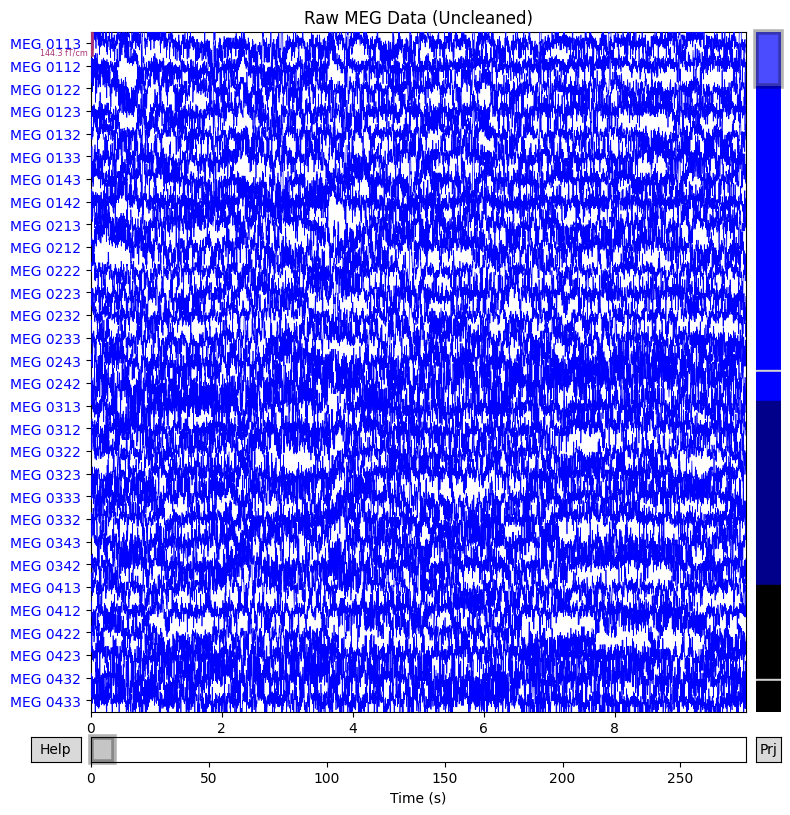

In [2]:
raw = load_meg_sample()
plot_raw(raw, title="Raw MEG Data (Uncleaned)")

### Bandpass Filtering: Removing Artifacts at Frequency Extremes

A bandpass filter is defined by two cut-off frequencies: **a lower limit ($l\_freq$)** and an **upper limit ($h\_freq$)**. Signals between these limits are preserved (passed), while those outside are attenuated.
- **Low-Frequency (High-Pass)**: Removing noise below $l\_freq$ (e.g., 1 Hz). This eliminates slow, large-amplitude DC drifts caused by temperature changes, subject movement, or galvanic skin response (sweating). These artifacts severely skew spectral analysis.
- **High-Frequency (Low-Pass)**: Removing noise above $h\_freq$ (e.g., 40 Hz). This reduces high-frequency **muscle activity (EMG)** and systemic hardware/quantization noise, improving the overall smoothness of the signal.

We use a **Finite Impulse Response (FIR) filter** because it can be implemented with **zero-phase distortion**, meaning the filter does not shift the timing of the remaining signals—crucial for time-sensitive analysis like Event-Related Potentials (ERPs).


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1983 samples (3.302 s)



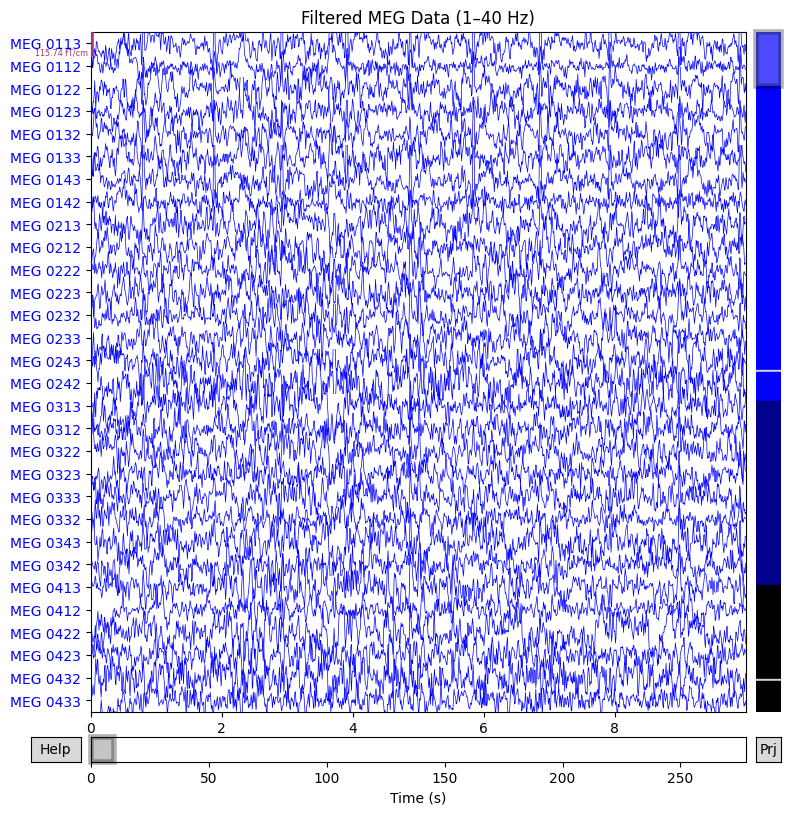

In [3]:
raw_filt = apply_bandpass_filter(raw.copy(), l_freq=1.0, h_freq=40.0)
plot_raw(raw_filt, title="Filtered MEG Data (1–40 Hz)")

### Notch Filtering (Powerline Noise): Targeting Specific Frequencies

Powerline interference (the **AC hum**) is a predictable, sinusoidal noise source generated by electrical grids. It appears as a sharp spectral peak at:
- 50 Hz (most of Europe, Asia, Africa)
- 60 Hz (North and South America)

A **notch filter** is a highly specialized **band-stop filter** designed to create a deep, extremely **narrow attenuation** (the "notch") centered precisely at the target frequency (e.g., 50 Hz) and its harmonics (e.g., 100 Hz, 150 Hz).

This filter is essential because:

1. It removes the powerline contamination **without affecting nearby frequencies**, preserving underlying neural oscillations (e.g., preserving $\gamma$-band activity near 40 Hz).
2. By targeting only a tiny frequency range, it minimizes the loss of neural data that a wider, standard band-stop filter would cause.

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3965 samples (6.602 s)



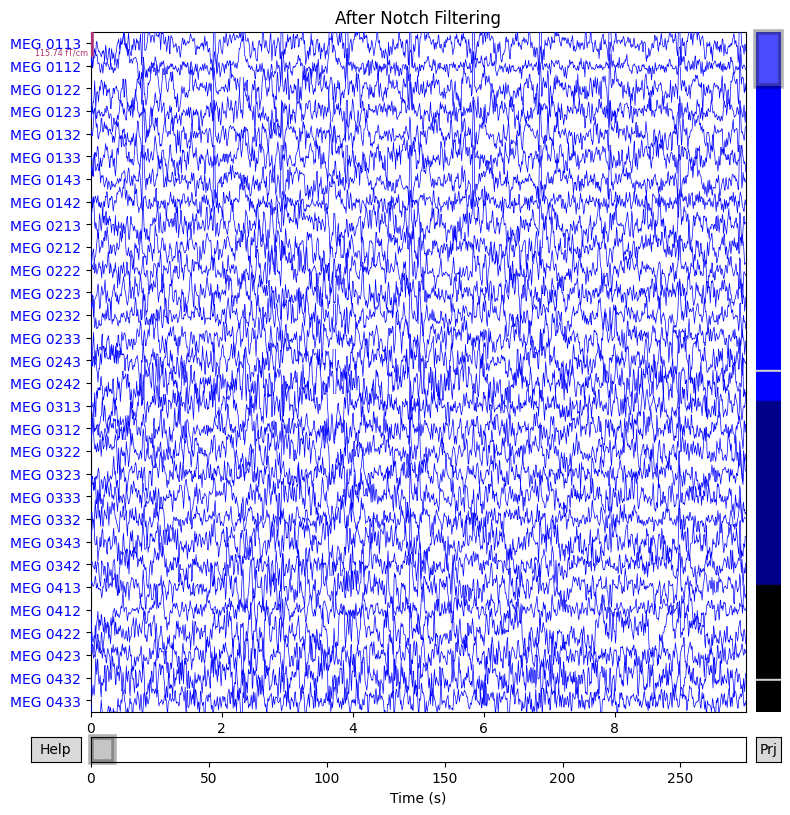

In [4]:
raw_notch = apply_notch_filter(raw_filt.copy(), freqs=[50, 100])
plot_raw(raw_notch, title="After Notch Filtering")

### Independent Component Analysis (ICA): A Powerful Artifact Separator

**ICA** is an advanced, data-driven blind source separation algorithm. Unlike standard filtering, which works in the frequency domain, ICA works in the **time domain** to untangle superimposed signals.

The core assumption is that the signals measured at the sensors are a linear mixture of several **statistically independent source signals** (components) originating from different biological or non-biological processes.

**How it works**:
1. **Decomposition**: The algorithm (e.g., FastICA) computes a mixing matrix ($A$) and an unmixing matrix ($W$). It estimates independent components ($S$) such that the sensor data ($X$) is $X = A \cdot S$.
2. **Artifact Identification**: ICA is excellent at isolating artifacts because they often exhibit unique time courses and spatial patterns:
   - **Eye Blinks/Movements (EOG)**: Very large, sharp deflections focused on frontal electrodes.
   - **Heartbeat (ECG)**: Repetitive, pulsatile pattern localized near the heart/major arteries (especially in MEG).
   - **Muscle Artifacts (EMG)**: High-frequency, noisy patterns.
3. **Subtraction**: The component maps identified as artifacts are zeroed out.
4. **Reconstruction**: The remaining, cleaned components are mixed back together to create the artifact-free sensor data.

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.8s.


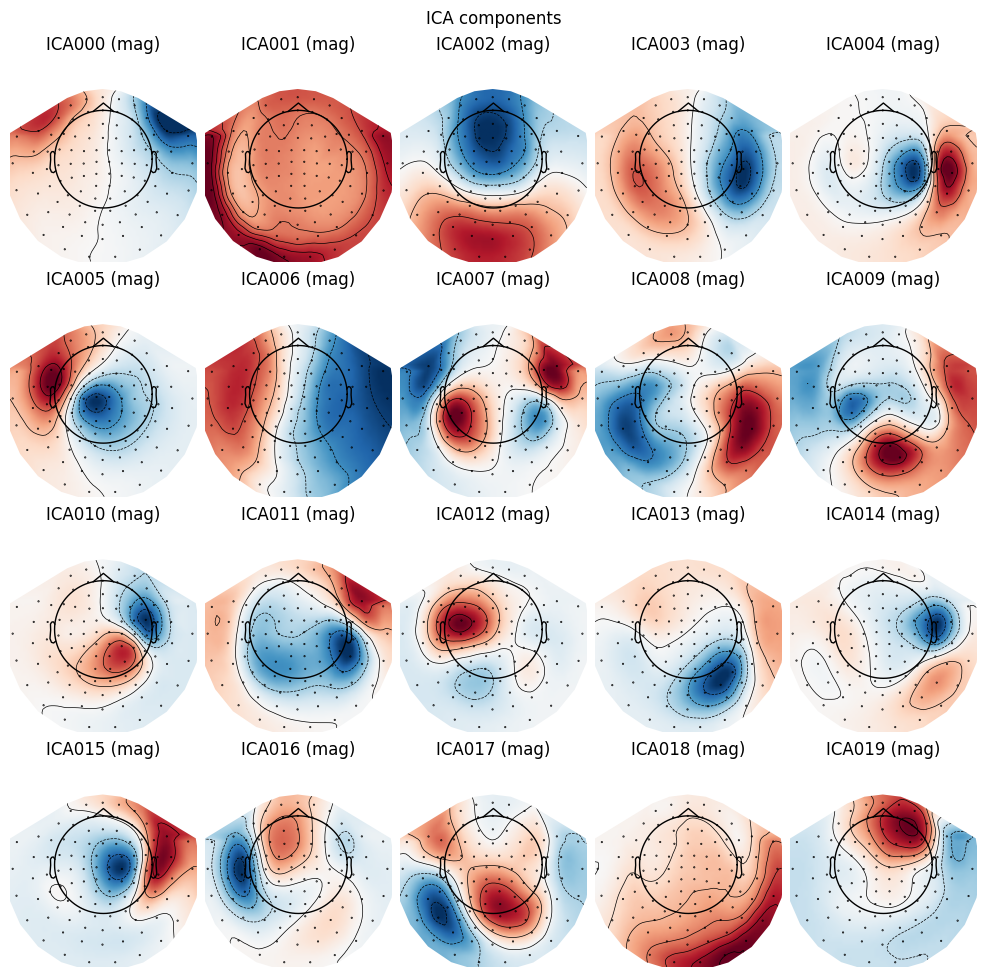

In [5]:
ica = compute_ica(raw_notch.copy(), n_components=20)
ica.plot_components(show=False)

### Automatically Detect Artifact Components

We detect typical artifact components using MNE's matching routines:
- `ica.find_bads_eog` → finds blink/movement components
- `ica.find_bads_ecg` → finds heartbeat components


In [6]:
eog_inds, _ = ica.find_bads_eog(raw_notch)
ecg_inds, _ = ica.find_bads_ecg(raw_notch)

ica.exclude = eog_inds + ecg_inds
ica.exclude

Using EOG channel: EOG 061
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6007 samples (10.001 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz

[np.int64(0), np.int64(1), np.int64(18), np.int64(6)]

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 364 PCA components


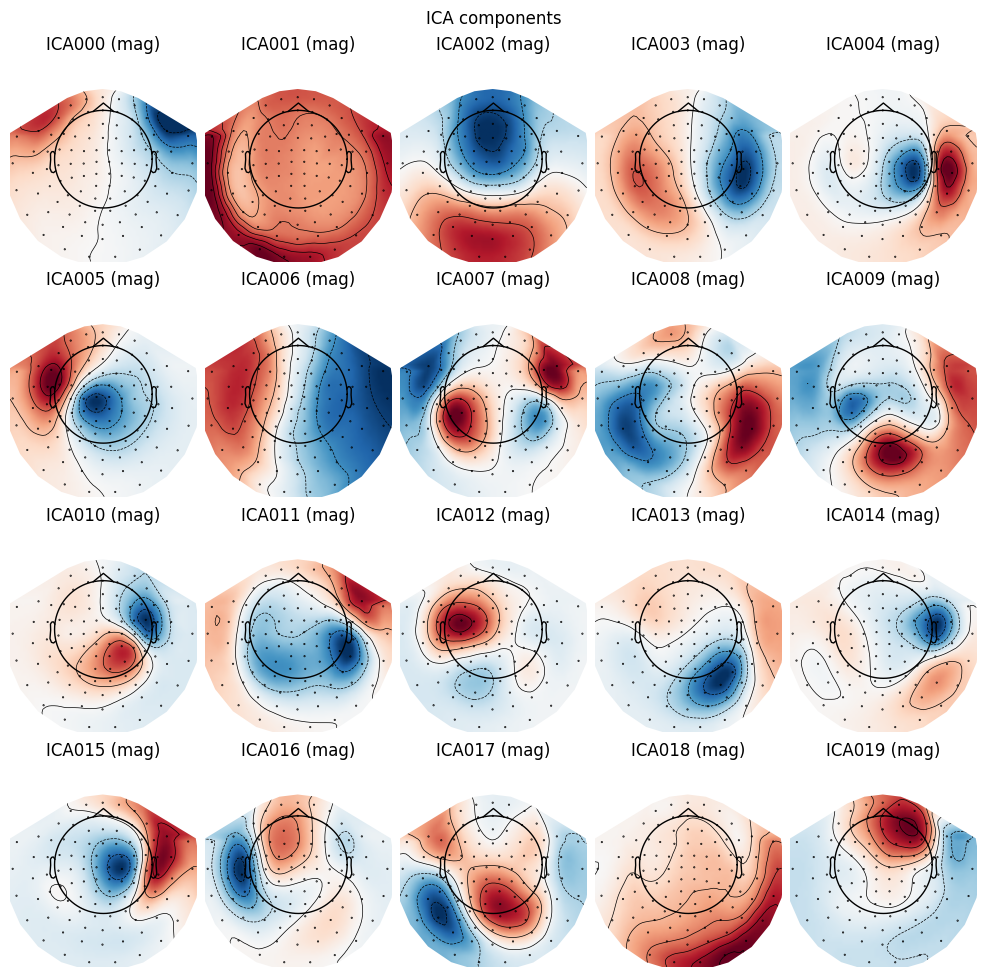

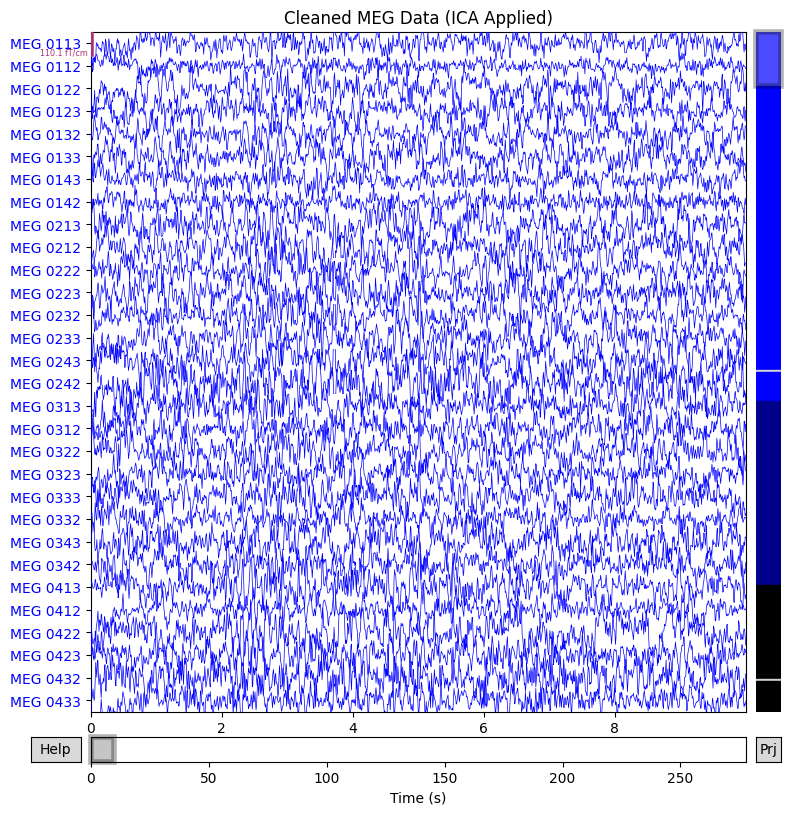

In [7]:
raw_clean = apply_ica_to_raw(raw_notch.copy(), ica)
plot_raw(raw_clean, title="Cleaned MEG Data (ICA Applied)")